# Dataset and Data Loading

In [49]:
from typing import List, Optional
import einops
import torch
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import pandas as pd
import os
import numpy as np
from skimage.color import gray2rgb

## Dataset

Here is the code for our dataset:

In [1]:

SEEDS = {
    'test': 1, 
    'val': 2
}

class CXRDataset(Dataset):
    
    def __init__(
            self, 
            root, 
            split='train', 
            resample_val=False,
            ignore_negatives=True, 
            to_tensor=True
        ):
        
        super().__init__()
        
        self.root = root
        self.split = split
        self.to_tensor = to_tensor
        
        self.metadata = pd.read_csv(
            os.path.join(root, 'metadata.csv'),
            index_col=0
        )

        idx_df = self.__get_idx_df(root, resample_val)
        
        # add labels
        idx_df = pd.merge(
            idx_df, 
            self.metadata[['img_name', 'label']].drop_duplicates(), 
            on='img_name', 
            how='inner'
        )
        
        # extract split
        if split:
            assert split in ['train', 'val', 'test']
            idx_df = idx_df.loc[idx_df['split'] == split]
        
        if ignore_negatives:
            idx_df = idx_df.loc[idx_df['label'] == 1]
        
        self.idx_df = idx_df.reset_index(drop=True)
        
    def __len__(self):
        return len(self.idx_df)
    
    def __getitem__(self, idx):
        
        try:
            img_name = self.idx_df.loc[idx, 'img_name']
        except KeyError:
            raise IndexError    
            
        item_metadata = self.metadata.loc[self.metadata.img_name == img_name]
        
        pixel_values = self.__read_mdh_to_numpy(
            os.path.join(
                self.root, 
                'images', 
                img_name)
        )
        
        bounding_boxes = []
        for row in item_metadata.iloc:
            d = dict(row)
            d.pop('img_name')
            bounding_boxes.append(d)
        
        max_ = np.max(pixel_values)
        min_ = np.min(pixel_values)
        pixel_values = (pixel_values - min_)/(max_ - min_)
        
        bounding_boxes = pd.DataFrame(bounding_boxes)
        pixel_values = gray2rgb(pixel_values)
        
        if self.to_tensor:
            values = bounding_boxes[['x', 'y', 'width', 'height']].values
            bounding_boxes = torch.tensor(values)
        
            pixel_values = einops.rearrange(
                pixel_values, 'h w c -> c h w', 
                h = 1024, 
                w = 1024, 
                c = 3
            )
            pixel_values = torch.tensor(pixel_values)
        
        return pixel_values, bounding_boxes      
    
    @staticmethod
    def __read_mdh_to_numpy(filename: str):
        
        img = sitk.ReadImage(filename)
        array = sitk.GetArrayFromImage(img)
        
        return array
    
    @staticmethod
    def __get_idx_df(root, resample_val):
        
        idx_df = pd.DataFrame(
                os.listdir(os.path.join(root, 'images')), 
                columns=['img_name']
            ).sort_values(by='img_name').reset_index(drop=True)
        
        idx_df['split'] = pd.Series(dtype='object')

        # generate masks
        
        rng = np.random.RandomState(seed=SEEDS['test'])
        test_mask = rng.rand(len(idx_df)) >= 0.8

        rng = np.random.RandomState(seed=None if resample_val else SEEDS['val'])
        val_mask = np.logical_and(rng.rand(len(idx_df)) >= 0.9, ~test_mask)

        train_mask = np.logical_and(~val_mask, ~test_mask)
        
        idx_df['split'] = idx_df['split'].mask(test_mask, 'test')
        idx_df['split'] = idx_df['split'].mask(val_mask, 'val')
        idx_df['split'] = idx_df['split'].mask(train_mask, 'train')
    
        idx_df.to_csv(
            os.path.join(root, 'split_info.csv'),
            header=True
        )
        
        return idx_df
    

Let's instantiate the dataset using the path to the data directory:

In [2]:
root = '/Users/paulwilson/data/node_21/cxr_images/proccessed_data'

First, we instantiate it with the flag 'to tensor' clear, so that we can take a look at the items:

In [6]:
ds = CXRDataset(root, to_tensor=False)
pixel_values, bounding_boxes = ds[9]

Let's show the chest x-ray image, and look at the corresponding bounding box:

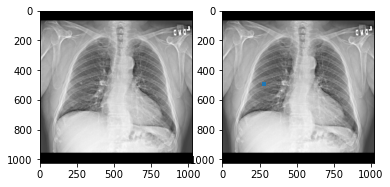

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pixel_values)
ax2.imshow(pixel_values)

x, y, w, h = bounding_boxes.loc[0, ['x', 'y', 'width', 'height']]

rectangle = Rectangle((x, y), w, h)
ax2.add_patch(rectangle)

## Data Loading

For this section, we will set the "to_tensor" flag to true so that we are dealing with the data as it will be actually used during training:

In [26]:
ds = CXRDataset(root)

Because of the format of our data, we need to put a little more thought into the way we load it. Normally, a dataloader class collates data items by stacking them across a new batch dimension. However, our data items are of the form 
`pixel_values, true_boxes`, 
which are both tensors. Pixel values consistently has the shape (3, 1024, 1024), but true boxes has shape (N, 4), where N is the number of nodules in the image - this number can be of varying length. Because it can be of varying length, we cannot simply stack along a batch dimension. We must instead use a special collate function where we concatenate the true boxes along their N dimension, but also include an indexing tensor with the batch to specify which item in the batch the true boxes came from. 

In [27]:
items = [ds[idx] for idx in range(2)]

the pixel values can simply be stacked together as usual. the expected shape is 2, 3, 1024, 1024. 

In [28]:
pixel_values = [ pixel_values for (pixel_values, _) in items]

pixel_values = torch.stack(pixel_values, dim=0)
    
pixel_values.shape

torch.Size([2, 3, 1024, 1024])

The true boxes have to be collated as described above:

In [29]:
true_boxes = [ true_boxes for (_, true_boxes) in items]

indices = []
for i in range(len(true_boxes)):
    indices.extend( [i] * len(true_boxes[i]) )
indices = torch.tensor( indices )
true_boxes = torch.concat(true_boxes, axis=0)

In [32]:
true_boxes, indices

(tensor([[709, 408, 108,  93],
         [804, 445,  40,  47]]),
 tensor([0, 1]))

Therefore, we use this collate function:

In [35]:
def collate_items(items: List[torch.Tensor]):
    
    pixel_values = [ pixel_values for (pixel_values, _) in items]
    pixel_values = torch.stack(pixel_values, dim=0)
    
    true_boxes = [ true_boxes for (_, true_boxes) in items]

    true_box_indices = []
    for i in range(len(true_boxes)):
        true_box_indices.extend( [i] * len(true_boxes[i]) )
    true_box_indices = torch.tensor( true_box_indices )
    true_boxes = torch.concat(true_boxes, axis=0)
    
    return pixel_values, true_boxes, true_box_indices

Now, we should be able to instantiate our dataloader class and have it return tuples in the form above: 

In [41]:
dl = DataLoader(ds, batch_size=64, collate_fn=collate_items)

In [44]:
pixel_values, true_boxes, true_box_indices = next(iter(dl))

We note that this collation process is very fast, and returns the expected results. We can access the true boxes from a specific item in the batch like so:

In [48]:
desired_idx = 10
true_boxes[true_box_indices == desired_idx]

tensor([[245, 631,  47,  49]])

## Datamodule

Now we can build our data module class, which is a wrapper for data loaders and data sets using in training a pytorch lightning system. Its job is to instantiate the datasets when setup() is called and provide the training, validation, and test dataloaders. 

In [51]:
from pytorch_lightning import LightningDataModule

class CXRDataModule(LightningDataModule):
    
    def __init__(self, root: str, batch_size: int):
        
        self.root = root
        self.batch_size = batch_size
        self.collate_fn = collate_items
        
    def setup(self, stage: Optional[str] = None) -> None:
        
        self.train_ds = CXRDataset(root, split='train')
        self.val_ds = CXRDataset(root, split = 'val')
        self.test_ds = CXRDataset(root, split='test')

    def train_dataloader(self):
        return DataLoader(
            self.train_ds, 
            batch_size = self.batch_size, 
            collate_fn = self.collate_fn
        )      
        
    def val_dataloader(self):
        return DataLoader(
            self.val_ds, 
            batch_size = self.batch_size, 
            collate_fn = self.collate_fn
        )    
    
    def test_dataloader(self):
        return DataLoader(
            self.test_ds, 
            batch_size = self.batch_size, 
            collate_fn = self.collate_fn
        )    

In [54]:
dm = CXRDataModule(root, batch_size=4)
dm.setup()
dataloader = dm.train_dataloader()
batch = next(iter(dataloader))
batch

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

Looks like everything is working perfectly!